<a href="https://colab.research.google.com/github/SFStefenon/EWT-Seq2Seq-LSTM-Attention/blob/main/EWT-Seq2Seq-LSTM-Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimized EWT-Seq2Seq-LSTM with Attention Mechanism

Wrote by Dr. **Laio Oriel Seman** and Dr. **Stefano Frizzo Stefenon**. 

Trento, Italy, March 10, 2023.


The proposed analysis is divided according to the models evaluated, according to:

> **Seq2Seq-LSTM with Attention**: Evaluation of the starting model using the Attention Mechanism.

> **Optimized Seq2Seq-LSTM with Attention**: Evaluation of the model with the optimized hyperparameters (based on Optuna).

> **Standard Seq2Seq LSTM**: Standard model for comparative purposes.







The definition of the number of epochs and the number of experiments results in a significant variation in simulation time.


In [36]:
# Number of epochs
# Recommended at least 100 for a complete evaluation
epc = 10

# Number of experiments to perform a statistical analysis
# Recommended at least 50 when statistical is evaluated
statistics = 5

# Import Libraries

In [37]:
import numpy as np
import pandas as pd 
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
font = {'weight': 'normal',	'size': 8}
matplotlib.rc('font', **font)
matplotlib.style.use('bmh')

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping

!pip install -q ewtpy
import ewtpy
!pip install -q optuna
import optuna
!pip install -q phik
import phik
from phik import resources, report

# Load the Dataset

In [38]:
# Load the dataset
mydata=np.loadtxt('Data.csv', delimiter=",", dtype=np.float32, skiprows=1)

insu1=mydata[:,[0]]
insu2=mydata[:,[1]] 
insu3=mydata[:,[2]] 
insu4=mydata[:,[3]] 
insu5=mydata[:,[4]] 
insu6=mydata[:,[5]] 

Definition of the insulators based on the correlation of the time series.

In [62]:
# Preparing the dataset
x1 = insu1[::100].flatten()
x2 = insu2[::100].flatten()
x3 = insu3[::100].flatten()
x4 = insu4[::100].flatten()
x5 = insu5[::100].flatten()
x6 = insu6[::100].flatten()

# Creating the dataframe
dfphi = pd.DataFrame({'Insulator 1': x1, 'Insulator 2': x2, 'Insulator 3': x3, 'Insulator 4': x4, 'Insulator 5': x5, 'Insulator 6': x6})

# Generating the report (report with the correlation)
# report.correlation_report(dfphi, pdf_file_name='report.pdf')

In this evaluation, samples 2 and 3 had the best correlation. For this reason, they were considered for the sequence-to-sequence evaluation.

In [40]:
# Definition of a limit (after that the flashover happens)
insu2_limit = insu2[:94000]
insu3_limit = insu3[:94000]

# Preprocessing (downsample)
x1 = insu2_limit[::100]
x2 = insu3_limit[::100]

\begin{tabular}{lrrrrrr}
\toprule
{} &  Insulator 1 &  Insulator 2 &  Insulator 3 &  Insulator 4 &  Insulator 5 &  Insulator 6 \\
\midrule
Mean      &       0.0895 &       0.1189 &       0.1232 &       0.0624 &       0.0274 &       0.0491 \\
Median    &       0.1320 &       0.1040 &       0.1180 &       0.0950 &       0.0380 &       0.0500 \\
Mode      &       0.0000 &       0.1030 &       0.1170 &       0.0000 &       0.0000 &       0.0000 \\
Range     &       0.2640 &       0.2270 &       0.2660 &       0.1930 &       0.1710 &       0.7550 \\
Variance  &       0.0059 &       0.0017 &       0.0019 &       0.0022 &       0.0006 &       0.0026 \\
Std. Dev. &       0.0771 &       0.0416 &       0.0431 &       0.0464 &       0.0240 &       0.0511 \\
25th \%ile &       0.0000 &       0.1020 &       0.1120 &       0.0000 &       0.0000 &       0.0000 \\
50th \%ile &       0.1320 &       0.1040 &       0.1180 &       0.0950 &       0.0380 &       0.0500 \\
75th \%ile &       0.1380 &       0

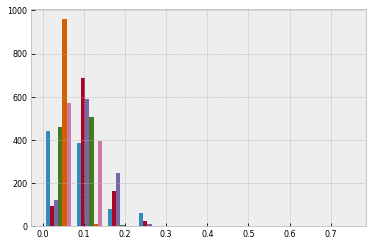

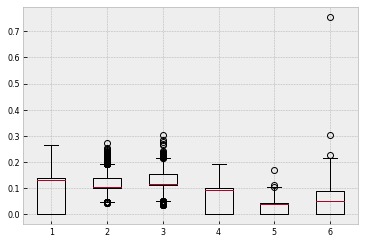

In [41]:
# Statistical characteristics

# calculate statistics
summary_df = pd.DataFrame({
    'Mean': dfphi.mean(),
    'Median': dfphi.median(),
    'Mode': dfphi.mode().iloc[0],
    'Range': dfphi.max() - dfphi.min(),
    'Variance': dfphi.var(),
    'Std. Dev.': dfphi.std(),
    '25th %ile': dfphi.quantile(0.25),
    '50th %ile': dfphi.quantile(0.50),
    '75th %ile': dfphi.quantile(0.75),
    'IQR': dfphi.quantile(0.75) - dfphi.quantile(0.25),
    'Skewness': dfphi.skew(),
    'Kurtosis': dfphi.kurtosis()
})

# print summary to latex
print(summary_df.transpose().round(4).to_latex())
# plot histogram and boxplot
plt.hist(dfphi, bins=10)
plt.show()
plt.boxplot(dfphi)
plt.show()

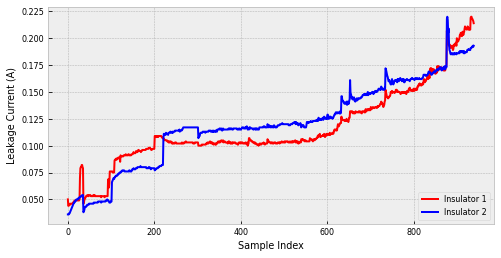

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(x1)), x1, 'r', zorder=2, label='Insulator 1')
plt.plot(range(len(x2)), x2, 'b', zorder=2, label='Insulator 2')
plt.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.xlabel('Sample Index')
plt.ylabel('Leakage Current (A)')
plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
plt.show()
# plt.savefig('LeakageCurrent.pdf')

# Empirical Wavelet Transform (EWT)

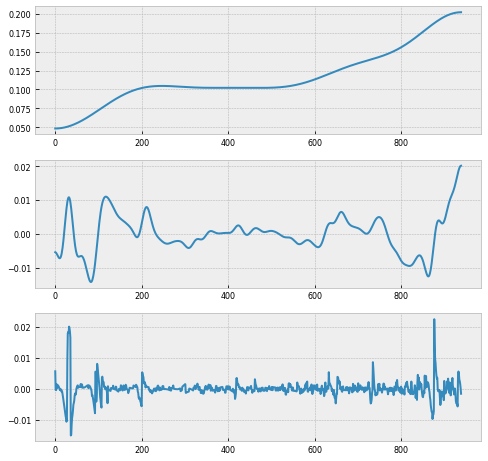

In [43]:
f1 = x1.flatten()
f2 = x2.flatten()

ewt1, mfb1, boundaries1 = ewtpy.EWT1D(f1, N = 3)
ewt2, mfb2, boundaries2 = ewtpy.EWT1D(f2, N = 3)

plt.figure(figsize=(8, 8))
for i in range(ewt1.shape[1]):
    plt.subplot(ewt1.shape[1], 1, i+1)
    plt.plot(ewt1[:,i])
    plt.grid(linestyle = '--', linewidth = 0.5, zorder=0)
    # plt.savefig('EWT.pdf')

<function matplotlib.pyplot.show(close=None, block=None)>

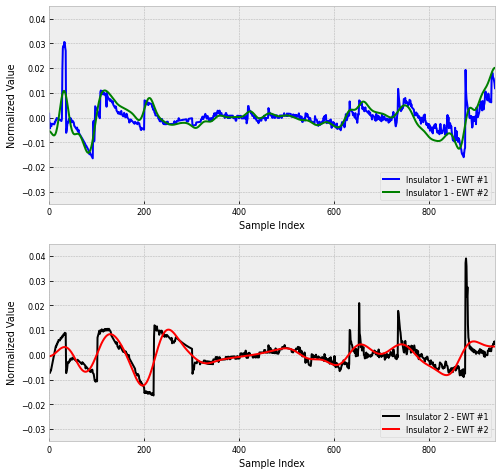

In [44]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(x1.flatten() - ewt1[:,0], 'b', zorder=2, label='Insulator 1 - EWT #1')
ax1.plot(ewt1[:,1], 'g', zorder=2, label='Insulator 1 - EWT #2')
ax1.set_ylabel('Normalized Value')
ax1.set_xlabel('Sample Index')
ax1.axis([0, len(x1), -0.035, 0.045])
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)

ax2.plot(x2.flatten() - ewt2[:,0], 'k', zorder=2, label='Insulator 2 - EWT #1')
ax2.plot(ewt2[:,1], 'r', zorder=2, label='Insulator 2 - EWT #2')
ax2.set_ylabel('Normalized Value')
ax2.set_xlabel('Sample Index')
ax2.axis([0, len(x1), -0.035, 0.045])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show 
# plt.savefig('Normalized.pdf')

## Organize the data

In [45]:
# Definition of dataset setup for comparison
train_ratio = 0.7
batch_siz = 16

t = np.linspace(0, 50*np.pi, len(x1))
train_len = int(train_ratio * t.shape[0])
x_index = np.array(range(len(t)))

In [46]:
# Data normalization
x_lbl = np.column_stack([x1.flatten() - ewt1[:,0], ewt1[:,1], x2.flatten() - ewt2[:,0], ewt2[:,1], [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)

# Perform min-max normalization
x_normalize = x_lbl.copy()

(940, 5)


In [47]:
# Organized truncat, smaller train_len and smaller test_len, to decrease the steps
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)

X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(4), target_cols=range(4), 
                            label_col=4, train_len=10, test_len=5)
print(X_in.shape, X_out.shape, lbl.shape)

X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]

(926, 10, 4) (926, 5, 4) (926,)


# Model Evaluation 1: Seq2Seq-LSTM with Attention

## Model evaluation

In [48]:
# Initial number of hidden neurons
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)

train_loss = history.history['loss']
valid_loss = history.history['val_loss']
mse = history.history['mse']
mae = history.history['mae']
mape = history.history['mape']
model.save('model_forecasting_seq2seq.h5')

train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
train_true_detrend = X_output_train[:, :, :TOTAL]
test_true_detrend = X_output_test[:, :, :TOTAL]
data_final = dict()

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/10
33/33 [==============================] - 21s 350ms/step - loss: 9.9230e-05 - mse: 9.9230e-05 - mae: 0.0068 - mape: 763.3102 - val_loss: 3.9306e-05 - val_mse: 3.9306e-05 - val_mae: 0.0052 - val_mape: 959.5040
Epoch 2/10
33/33 [==============================] - 7s 226ms/step - loss: 2.3057e-05 - mse: 2.3057e-05 - mae: 0.0034 - mape: 361.8282 - val_loss: 8.8761e-05 - val_mse: 8.8761e-05 - val_mae: 0.0082 - val_mape: 1498.7302
Epoch 3/10
33/33 [==============================] - 8s 227ms/step - loss: 2.5866e-05 - mse: 2.5866e-05 - mae: 0.0036 - mape: 358.7850 - val_loss: 2.3543e-05 - val_mse: 2.3543e-05 - val_mae: 0.0039 - val_mape: 692.0515
Epoch 4/10
33/33 [==============================] - 9s 288ms/step - loss: 2.0085e-05 - mse: 2.0085e-05 - mae: 0.0033 - mape: 374.1750 - val_loss: 3.7251e-05 - val_mse: 3.7251e-05 - val_mae: 0.0052 - val_mape: 1421.6375
Epoch 5/10
33/33 [==============================] - 9s 261ms/step - loss: 2.0362e-05 - mse: 2.0362e-05 - mae: 0.0033 - mape: 

## Plot Result

<function matplotlib.pyplot.show(close=None, block=None)>

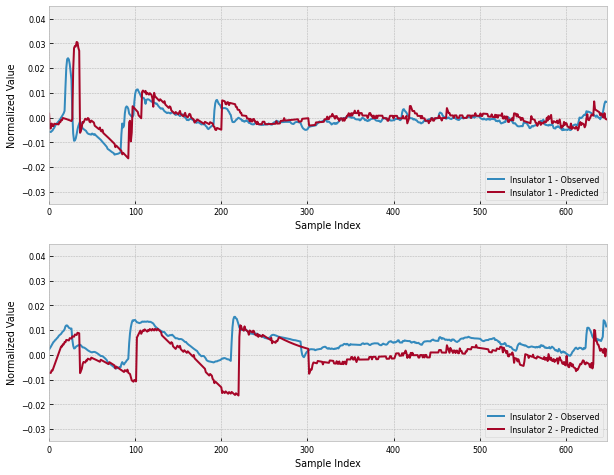

In [49]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(train_pred_detrend[:,0,0], zorder=2, label='Insulator 1 - Observed')
ax1.plot(X_input_train[:,0,0], zorder=2, label='Insulator 1 - Predicted')
ax1.set_ylabel('Normalized Value')
ax1.set_xlabel('Sample Index')
ax1.axis([0, len(train_pred_detrend[:,0,0]), -0.035, 0.045])
ax1.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax1.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)

ax2.plot(train_pred_detrend[:,0,2], zorder=2, label='Insulator 2 - Observed')
ax2.plot(X_input_train[:,0,2],zorder=2, label='Insulator 2 - Predicted')
ax2.set_ylabel('Normalized Value')
ax2.set_xlabel('Sample Index')
ax2.axis([0, len(train_pred_detrend[:,0,0]), -0.035, 0.045])
ax2.grid(linestyle = '--', linewidth = 0.5, zorder=0)
ax2.legend(loc='lower right', fancybox=True, shadow=False, ncol=1)
plt.show 
# plt.savefig('Pred_1.pdf')

# Hyperparameters Optimization (Optuna)

In [50]:
# EWT considered
TOTAL = 3

def attention(n_hidden, ativacao, lr):

    input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
    output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation=ativacao, dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
    encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
    encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
    decoder_stack_h = LSTM(n_hidden, activation=ativacao, dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    context = dot([attention, encoder_stack_h], axes=[2,1])
    context = BatchNormalization(momentum=0.6)(context)

    decoder_combined_context = concatenate([context, decoder_stack_h])
    out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)

    model = Model(inputs=input_train, outputs=out)
    opt = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

    for i in range(1):
        es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
        history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)

        train_loss = history.history['loss']
        valid_loss = history.history['val_loss']
        mse = history.history['mse']
        mae = history.history['mae']
        mape = history.history['mape']
        model.save('model_forecasting_seq2seq.h5')

        train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
        test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
        train_true_detrend = X_output_train[:, :, :TOTAL]
        test_true_detrend = X_output_test[:, :, :TOTAL]
        data_final = dict()

    return mse[-1]

def objective(trial):
    x = trial.suggest_int('hidden_units', 10, 100)
    ativacao = trial.suggest_categorical("activation", ['relu', 'elu', 'tanh'])
    lr = trial.suggest_float('learning_rate', 0.001, 0.1)
    erro = attention(x, ativacao, lr)
    return erro

study = optuna.create_study()
study.optimize(objective, n_trials=10)

study.best_params  # E.g. {'x': 2.002108042}

[I 2023-03-08 10:18:41,349] A new study created in memory with name: no-name-d4e4955c-dfe7-4ef8-b609-91e008e48dfc


Epoch 1/10
33/33 [==============================] - 11s 90ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0368 - mape: 5780.2383 - val_loss: 1.6500e-04 - val_mse: 1.6500e-04 - val_mae: 0.0122 - val_mape: 2309.5022
Epoch 2/10
33/33 [==============================] - 2s 73ms/step - loss: 8.8740e-05 - mse: 8.8740e-05 - mae: 0.0074 - mape: 960.0483 - val_loss: 8.9912e-06 - val_mse: 8.9912e-06 - val_mae: 0.0021 - val_mape: 499.6225
Epoch 3/10
33/33 [==============================] - 4s 121ms/step - loss: 5.4897e-05 - mse: 5.4897e-05 - mae: 0.0054 - mape: 513.3040 - val_loss: 3.6733e-05 - val_mse: 3.6733e-05 - val_mae: 0.0050 - val_mape: 1417.2307
Epoch 4/10
33/33 [==============================] - 2s 74ms/step - loss: 4.5915e-05 - mse: 4.5915e-05 - mae: 0.0052 - mape: 579.9791 - val_loss: 2.1365e-05 - val_mse: 2.1365e-05 - val_mae: 0.0036 - val_mape: 717.6070
Epoch 5/10
33/33 [==============================] - 2s 68ms/step - loss: 4.2399e-05 - mse: 4.2399e-05 - mae: 0.0048 - mape: 486.5832 - 

[I 2023-03-08 10:19:17,488] Trial 0 finished with value: 5.781467189081013e-05 and parameters: {'hidden_units': 21, 'activation': 'relu', 'learning_rate': 0.06484136434434554}. Best is trial 0 with value: 5.781467189081013e-05.


Epoch 1/10
33/33 [==============================] - 10s 87ms/step - loss: 0.0547 - mse: 0.0547 - mae: 0.1389 - mape: 23620.2480 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0878 - val_mape: 16602.1133
Epoch 2/10
33/33 [==============================] - 3s 77ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0256 - mape: 3419.6348 - val_loss: 1.1039e-04 - val_mse: 1.1039e-04 - val_mae: 0.0100 - val_mape: 1776.7864
Epoch 3/10
33/33 [==============================] - 2s 70ms/step - loss: 2.9088e-04 - mse: 2.9088e-04 - mae: 0.0134 - mape: 1846.3573 - val_loss: 1.3698e-05 - val_mse: 1.3698e-05 - val_mae: 0.0027 - val_mape: 869.4894
Epoch 4/10
33/33 [==============================] - 4s 116ms/step - loss: 1.7011e-04 - mse: 1.7011e-04 - mae: 0.0104 - mape: 1480.4701 - val_loss: 1.7278e-05 - val_mse: 1.7278e-05 - val_mae: 0.0035 - val_mape: 610.2596
Epoch 5/10
33/33 [==============================] - 2s 69ms/step - loss: 1.4215e-04 - mse: 1.4215e-04 - mae: 0.0094 - mape: 1292.3822 - val_loss: 

[I 2023-03-08 10:19:55,287] Trial 1 finished with value: 6.914015830261633e-05 and parameters: {'hidden_units': 98, 'activation': 'tanh', 'learning_rate': 0.04706154298944654}. Best is trial 0 with value: 5.781467189081013e-05.


Epoch 1/10
33/33 [==============================] - 11s 89ms/step - loss: 0.1398 - mse: 0.1398 - mae: 0.2152 - mape: 28342.2988 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0645 - val_mape: 9163.9023
Epoch 2/10
33/33 [==============================] - 2s 69ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0241 - mape: 3209.8738 - val_loss: 5.9597e-05 - val_mse: 5.9597e-05 - val_mae: 0.0066 - val_mape: 1266.6675
Epoch 3/10
33/33 [==============================] - 2s 71ms/step - loss: 6.7666e-05 - mse: 6.7666e-05 - mae: 0.0064 - mape: 718.5296 - val_loss: 1.8330e-05 - val_mse: 1.8330e-05 - val_mae: 0.0032 - val_mape: 570.0695
Epoch 4/10
33/33 [==============================] - 4s 117ms/step - loss: 3.9091e-05 - mse: 3.9091e-05 - mae: 0.0046 - mape: 411.8610 - val_loss: 1.0028e-05 - val_mse: 1.0028e-05 - val_mae: 0.0022 - val_mape: 219.8343
Epoch 5/10
33/33 [==============================] - 2s 71ms/step - loss: 4.2819e-05 - mse: 4.2819e-05 - mae: 0.0050 - mape: 506.0745 - val_loss: 1.05

[I 2023-03-08 10:20:33,166] Trial 2 finished with value: 4.114467810722999e-05 and parameters: {'hidden_units': 54, 'activation': 'relu', 'learning_rate': 0.09451458815589033}. Best is trial 2 with value: 4.114467810722999e-05.


Epoch 1/10
33/33 [==============================] - 10s 86ms/step - loss: 4.6106e-04 - mse: 4.6106e-04 - mae: 0.0143 - mape: 1914.8356 - val_loss: 2.6349e-04 - val_mse: 2.6349e-04 - val_mae: 0.0149 - val_mape: 3136.6257
Epoch 2/10
33/33 [==============================] - 2s 67ms/step - loss: 3.4087e-05 - mse: 3.4087e-05 - mae: 0.0043 - mape: 461.7641 - val_loss: 1.6100e-05 - val_mse: 1.6100e-05 - val_mae: 0.0032 - val_mape: 400.8388
Epoch 3/10
33/33 [==============================] - 2s 75ms/step - loss: 2.2816e-05 - mse: 2.2816e-05 - mae: 0.0035 - mape: 430.7337 - val_loss: 1.5884e-04 - val_mse: 1.5884e-04 - val_mae: 0.0120 - val_mape: 2139.3652
Epoch 4/10
33/33 [==============================] - 2s 72ms/step - loss: 2.5276e-05 - mse: 2.5276e-05 - mae: 0.0038 - mape: 444.4256 - val_loss: 5.8046e-05 - val_mse: 5.8046e-05 - val_mae: 0.0059 - val_mape: 1004.1661
Epoch 5/10
33/33 [==============================] - 4s 121ms/step - loss: 2.0038e-05 - mse: 2.0038e-05 - mae: 0.0034 - mape: 39

[I 2023-03-08 10:21:09,397] Trial 3 finished with value: 1.3180698260839563e-05 and parameters: {'hidden_units': 55, 'activation': 'tanh', 'learning_rate': 0.006665852047618611}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 12s 133ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0597 - mape: 9855.9512 - val_loss: 2.7972e-04 - val_mse: 2.7972e-04 - val_mae: 0.0113 - val_mape: 855.9052
Epoch 2/10
33/33 [==============================] - 2s 69ms/step - loss: 1.9362e-04 - mse: 1.9362e-04 - mae: 0.0106 - mape: 1493.7623 - val_loss: 2.1035e-05 - val_mse: 2.1035e-05 - val_mae: 0.0040 - val_mape: 539.6299
Epoch 3/10
33/33 [==============================] - 2s 74ms/step - loss: 7.1332e-05 - mse: 7.1332e-05 - mae: 0.0065 - mape: 799.8477 - val_loss: 3.3498e-05 - val_mse: 3.3498e-05 - val_mae: 0.0042 - val_mape: 1317.5273
Epoch 4/10
33/33 [==============================] - 2s 71ms/step - loss: 8.5744e-05 - mse: 8.5744e-05 - mae: 0.0071 - mape: 883.0882 - val_loss: 1.6172e-05 - val_mse: 1.6172e-05 - val_mae: 0.0031 - val_mape: 808.1838
Epoch 5/10
33/33 [==============================] - 4s 113ms/step - loss: 5.6608e-05 - mse: 5.6608e-05 - mae: 0.0059 - mape: 717.5046 -

[I 2023-03-08 10:21:46,973] Trial 4 finished with value: 4.11166220146697e-05 and parameters: {'hidden_units': 15, 'activation': 'elu', 'learning_rate': 0.08736319839939932}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 10s 114ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0326 - mape: 4909.1006 - val_loss: 6.3581e-05 - val_mse: 6.3581e-05 - val_mae: 0.0073 - val_mape: 878.2629
Epoch 2/10
33/33 [==============================] - 3s 88ms/step - loss: 5.9144e-05 - mse: 5.9144e-05 - mae: 0.0059 - mape: 633.4938 - val_loss: 2.9815e-05 - val_mse: 2.9815e-05 - val_mae: 0.0050 - val_mape: 664.1710
Epoch 3/10
33/33 [==============================] - 4s 126ms/step - loss: 4.1173e-05 - mse: 4.1173e-05 - mae: 0.0048 - mape: 510.1302 - val_loss: 1.1868e-05 - val_mse: 1.1868e-05 - val_mae: 0.0025 - val_mape: 576.9093
Epoch 4/10
33/33 [==============================] - 2s 68ms/step - loss: 3.6761e-05 - mse: 3.6761e-05 - mae: 0.0046 - mape: 440.0634 - val_loss: 1.9795e-05 - val_mse: 1.9795e-05 - val_mae: 0.0037 - val_mape: 490.8792
Epoch 5/10
33/33 [==============================] - 3s 94ms/step - loss: 3.8813e-05 - mse: 3.8813e-05 - mae: 0.0046 - mape: 437.6162 - v

[I 2023-03-08 10:22:24,188] Trial 5 finished with value: 4.598706800607033e-05 and parameters: {'hidden_units': 33, 'activation': 'relu', 'learning_rate': 0.05982477653030741}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 11s 124ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1139 - mape: 15623.9248 - val_loss: 3.8823e-04 - val_mse: 3.8823e-04 - val_mae: 0.0191 - val_mape: 3238.3682
Epoch 2/10
33/33 [==============================] - 3s 76ms/step - loss: 5.1440e-04 - mse: 5.1440e-04 - mae: 0.0171 - mape: 2328.4709 - val_loss: 1.0495e-04 - val_mse: 1.0495e-04 - val_mae: 0.0090 - val_mape: 1506.7008
Epoch 3/10
33/33 [==============================] - 3s 80ms/step - loss: 5.1370e-05 - mse: 5.1370e-05 - mae: 0.0053 - mape: 533.6994 - val_loss: 1.3988e-05 - val_mse: 1.3988e-05 - val_mae: 0.0028 - val_mape: 550.9458
Epoch 4/10
33/33 [==============================] - 2s 72ms/step - loss: 3.4293e-05 - mse: 3.4293e-05 - mae: 0.0043 - mape: 325.8804 - val_loss: 1.0444e-05 - val_mse: 1.0444e-05 - val_mae: 0.0023 - val_mape: 177.3898
Epoch 5/10
33/33 [==============================] - 3s 76ms/step - loss: 3.5825e-05 - mse: 3.5825e-05 - mae: 0.0044 - mape: 352.8716 

[I 2023-03-08 10:23:12,880] Trial 6 finished with value: 5.2861876611132175e-05 and parameters: {'hidden_units': 42, 'activation': 'relu', 'learning_rate': 0.09477842400314176}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 9s 85ms/step - loss: 4.0596e-04 - mse: 4.0596e-04 - mae: 0.0116 - mape: 1543.1323 - val_loss: 2.1026e-05 - val_mse: 2.1026e-05 - val_mae: 0.0032 - val_mape: 999.3383
Epoch 2/10
33/33 [==============================] - 4s 110ms/step - loss: 2.3534e-05 - mse: 2.3534e-05 - mae: 0.0034 - mape: 351.1693 - val_loss: 8.8866e-06 - val_mse: 8.8866e-06 - val_mae: 0.0021 - val_mape: 452.2025
Epoch 3/10
33/33 [==============================] - 3s 74ms/step - loss: 2.1599e-05 - mse: 2.1599e-05 - mae: 0.0033 - mape: 316.5752 - val_loss: 1.3991e-05 - val_mse: 1.3991e-05 - val_mae: 0.0033 - val_mape: 461.9550
Epoch 4/10
33/33 [==============================] - 2s 73ms/step - loss: 2.0551e-05 - mse: 2.0551e-05 - mae: 0.0032 - mape: 325.3643 - val_loss: 1.0043e-05 - val_mse: 1.0043e-05 - val_mae: 0.0026 - val_mape: 279.5262
Epoch 5/10
33/33 [==============================] - 2s 73ms/step - loss: 1.9738e-05 - mse: 1.9738e-05 - mae: 0.0032 - mape: 311.52

[I 2023-03-08 10:24:00,383] Trial 7 finished with value: 1.667535434535239e-05 and parameters: {'hidden_units': 71, 'activation': 'relu', 'learning_rate': 0.012720237240901659}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 12s 92ms/step - loss: 0.0105 - mse: 0.0105 - mae: 0.0544 - mape: 7537.2588 - val_loss: 5.0360e-04 - val_mse: 5.0360e-04 - val_mae: 0.0202 - val_mape: 2798.9124
Epoch 2/10
33/33 [==============================] - 4s 117ms/step - loss: 1.0739e-04 - mse: 1.0739e-04 - mae: 0.0077 - mape: 1098.1626 - val_loss: 2.5360e-05 - val_mse: 2.5360e-05 - val_mae: 0.0043 - val_mape: 813.4306
Epoch 3/10
33/33 [==============================] - 2s 75ms/step - loss: 3.1196e-05 - mse: 3.1196e-05 - mae: 0.0041 - mape: 387.7589 - val_loss: 2.0670e-05 - val_mse: 2.0670e-05 - val_mae: 0.0040 - val_mape: 431.7393
Epoch 4/10
33/33 [==============================] - 2s 76ms/step - loss: 3.9259e-05 - mse: 3.9259e-05 - mae: 0.0046 - mape: 452.0917 - val_loss: 3.4144e-05 - val_mse: 3.4144e-05 - val_mae: 0.0046 - val_mape: 1054.1998
Epoch 5/10
33/33 [==============================] - 2s 73ms/step - loss: 3.5326e-05 - mse: 3.5326e-05 - mae: 0.0046 - mape: 510.7399 -

[I 2023-03-08 10:24:38,585] Trial 8 finished with value: 5.2086343202972785e-05 and parameters: {'hidden_units': 61, 'activation': 'relu', 'learning_rate': 0.06203202636016546}. Best is trial 3 with value: 1.3180698260839563e-05.


Epoch 1/10
33/33 [==============================] - 10s 88ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0317 - mape: 5162.1064 - val_loss: 6.0856e-05 - val_mse: 6.0856e-05 - val_mae: 0.0067 - val_mape: 1556.3844
Epoch 2/10
33/33 [==============================] - 2s 73ms/step - loss: 7.1395e-05 - mse: 7.1395e-05 - mae: 0.0064 - mape: 872.3008 - val_loss: 2.0444e-05 - val_mse: 2.0444e-05 - val_mae: 0.0040 - val_mape: 602.4330
Epoch 3/10
33/33 [==============================] - 4s 116ms/step - loss: 2.7554e-05 - mse: 2.7554e-05 - mae: 0.0039 - mape: 469.0995 - val_loss: 5.9560e-06 - val_mse: 5.9560e-06 - val_mae: 0.0017 - val_mape: 394.3054
Epoch 4/10
33/33 [==============================] - 2s 72ms/step - loss: 2.4696e-05 - mse: 2.4696e-05 - mae: 0.0038 - mape: 444.3153 - val_loss: 1.2309e-05 - val_mse: 1.2309e-05 - val_mae: 0.0027 - val_mape: 671.4019
Epoch 5/10
33/33 [==============================] - 2s 74ms/step - loss: 2.5795e-05 - mse: 2.5795e-05 - mae: 0.0038 - mape: 418.2922 - v

[I 2023-03-08 10:25:26,411] Trial 9 finished with value: 2.0596218746504746e-05 and parameters: {'hidden_units': 78, 'activation': 'tanh', 'learning_rate': 0.01954834827002639}. Best is trial 3 with value: 1.3180698260839563e-05.


{'hidden_units': 55,
 'activation': 'tanh',
 'learning_rate': 0.006665852047618611}

In [63]:
optuna.visualization.plot_param_importances(study)

In [64]:
optuna.visualization.plot_contour(study, params=["hidden_units", "activation", "learning_rate"])

<ipython-input-65-e19d1e16c3db>:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

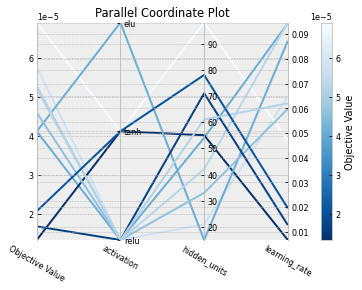

In [65]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_units", "activation", "learning_rate"])

# Model Evaluation 2: Optimized Seq2Seq-LSTM with Attention

## Model evaluation

In [54]:
# Number of hidden neurons defined by the optimizer
n_hidden = 78

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(n_hidden, activation='relu', dropout=0.2, recurrent_dropout=0.2, return_state=True, return_sequences=True)(input_train)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

# Activation function defined by the optimizer
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)

decoder_combined_context = concatenate([context, decoder_stack_h])
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
model = Model(inputs=input_train, outputs=out)

# Learning rate defined by the optimizer
opt = Adam(lr=0.013629063355056946, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

# To save values for statistics
MSE=[]
MAE=[]
MAPE=[]

for i in range(statistics):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
  test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
  train_true_detrend = X_output_train[:, :, :TOTAL]
  test_true_detrend = X_output_test[:, :, :TOTAL]
  data_final = dict()

  print(f'Simulation: {i+1}')
  MSE.append(mse[len(mse)-1])
  MAE.append(mae[len(mse)-1])
  MAPE.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/10
33/33 [==============================] - 12s 99ms/step - loss: 6.1478e-05 - mse: 6.1478e-05 - mae: 0.0054 - mape: 594.0910 - val_loss: 1.4076e-05 - val_mse: 1.4076e-05 - val_mae: 0.0029 - val_mape: 780.5535
Epoch 2/10
33/33 [==============================] - 4s 118ms/step - loss: 2.1260e-05 - mse: 2.1260e-05 - mae: 0.0033 - mape: 335.1744 - val_loss: 9.7513e-06 - val_mse: 9.7513e-06 - val_mae: 0.0025 - val_mape: 295.3814
Epoch 3/10
33/33 [==============================] - 2s 72ms/step - loss: 1.7877e-05 - mse: 1.7877e-05 - mae: 0.0029 - mape: 292.5012 - val_loss: 5.8970e-06 - val_mse: 5.8970e-06 - val_mae: 0.0016 - val_mape: 389.1134
Epoch 4/10
33/33 [==============================] - 3s 77ms/step - loss: 1.5386e-05 - mse: 1.5386e-05 - mae: 0.0026 - mape: 258.3474 - val_loss: 1.0270e-05 - val_mse: 1.0270e-05 - val_mae: 0.0024 - val_mape: 475.0370
Epoch 5/10
33/33 [==============================] - 2s 75ms/step - loss: 1.6411e-05 - mse: 1.6411e-05 - mae: 0.0029 - mape: 320.34

## Result analysis

[1.5875795725150965e-05, 1.2624807823158335e-05, 1.256215909961611e-05, 1.257236726814881e-05, 1.137718754762318e-05]
5


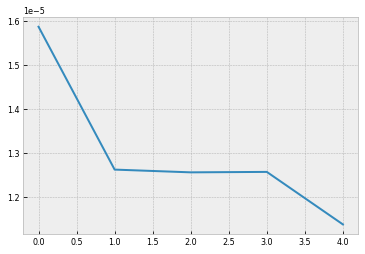

In [55]:
print(MSE)
plt.plot(MSE)
print(len(MSE))

In [56]:
# Save results to csv
pd.DataFrame(MAPE).to_csv("MAPE.csv", index=True)
pd.DataFrame(MAE).to_csv("MAE.csv", index=True)
pd.DataFrame(MSE).to_csv("MSE.csv", index=True)

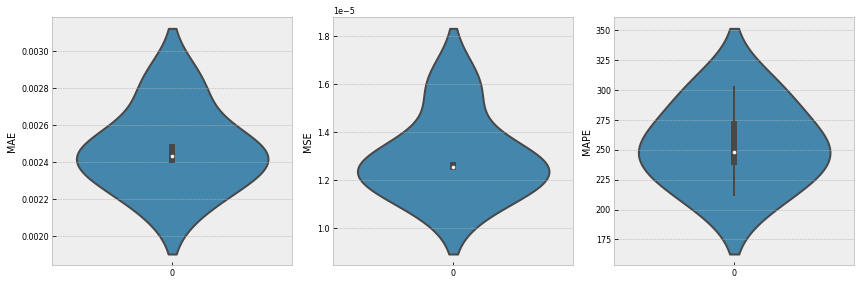

In [57]:
# Load the data from the CSV files
mape_df = pd.read_csv("MAPE.csv", index_col=0)
mae_df = pd.read_csv("MAE.csv", index_col=0)
mse_df = pd.read_csv("MSE.csv", index_col=0)

# Combine the data into a single DataFrame
data = pd.concat([mape_df, mae_df, mse_df], axis=1)
data.columns = ['MAPE', 'MAE', 'MSE']

# Create the violin plot using seaborn
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Create the violin plots and save them to the subplots
sns.violinplot(data=mae_df, ax=axs[0])
axs[0].set_ylabel("MAE")

sns.violinplot(data=mse_df, ax=axs[1])
axs[1].set_ylabel("MSE")

sns.violinplot(data=mape_df, ax=axs[2])
axs[2].set_ylabel("MAPE")

# Adjust the layout and save the figure
plt.tight_layout()
# plt.savefig("violinplots.pdf", dpi=400)

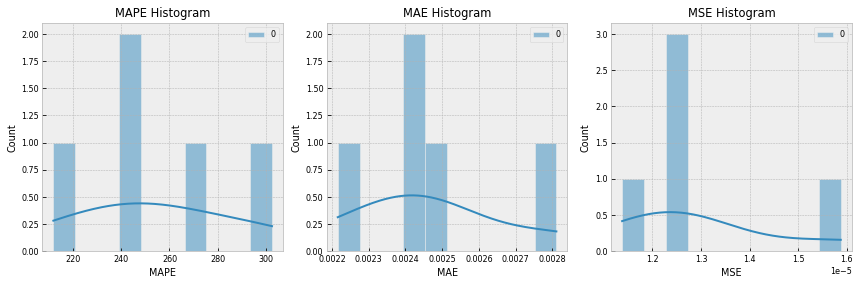

In [58]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the histograms for each variable
sns.histplot(data=mape_df, ax=axs[0], bins=10, kde=True, color='blue')
sns.histplot(data=mae_df, ax=axs[1], bins=10, kde=True, color='orange')
sns.histplot(data=mse_df, ax=axs[2], bins=10, kde=True, color='green')

# Set titles and axis labels
axs[0].set_title('MAPE Histogram')
axs[1].set_title('MAE Histogram')
axs[2].set_title('MSE Histogram')
axs[0].set_xlabel('MAPE')
axs[1].set_xlabel('MAE')
axs[2].set_xlabel('MSE')
# plt.suptitle('Distribution of Errors')

# Adjust the layout and save the figure
plt.tight_layout()
# plt.savefig("histograms.pdf", dpi=400)

In [59]:
!pip install -q pywt
import pywt

# Generate a signal to use for testing
signal = np.sin(np.linspace(0, 4*np.pi, num=100))

# Define the wavelet to use and the level of decomposition
wavelet = 'db4'
level = 4

# Perform the discrete wavelet transform (DWT)
coeffs = pywt.wavedec(signal, wavelet, level=level)

# Calculate the energy coefficients for each level of the DWT
energy_coeffs = []
for i in range(level+1):
    c = coeffs[i]
    energy_coeffs.append(np.sum(np.square(c)))

# Print the energy coefficients for each level
print("Energy coefficients:")
for i in range(level+1):
    print("Level {}: {}".format(i, energy_coeffs[i]))

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt
Energy coefficients:
Level 0: 51.33632444740844
Level 1: 5.769843287743957
Level 2: 0.7824475654049465
Level 3: 0.07040989273515635
Level 4: 0.0002251452294609961


/usr/local/lib/python3.8/dist-packages/pywt/_multilevel.py:43: UserWarning:

Level value of 4 is too high: all coefficients will experience boundary effects.



# Model Evaluation 3: Standard Seq2Seq LSTM Model

In [60]:
n_hidden = 100

input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_sequences=False, return_state=True)(input_train)
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

out = TimeDistributed(Dense(output_train.shape[2]))(decoder)

model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1) 
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', 'mape'])

# Evaluate the time for training the model
inicio = time.time()

# EWT considered
TOTAL = 3

# To save values for statistics
MSE=[]
MAE=[]
MAPE=[]

for i in range(statistics):
  es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
  history = model.fit(X_input_train[:, :, :TOTAL], X_output_train[:, :, :TOTAL], validation_split=0.2, epochs=epc, verbose=1, callbacks=[es], batch_size=batch_siz)
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  mse = history.history['mse']
  mae = history.history['mae']
  mape = history.history['mape']
  model.save('model_forecasting_seq2seq.h5')

  train_pred_detrend = model.predict(X_input_train[:, :, :TOTAL])
  test_pred_detrend = model.predict(X_input_test[:, :, :TOTAL])
  train_true_detrend = X_output_train[:, :, :TOTAL]
  test_true_detrend = X_output_test[:, :, :TOTAL]
  data_final = dict()
  
  print(f'Simulation: {i+1}')
  MSE.append(mse[len(mse)-1])
  MAE.append(mae[len(mse)-1])
  MAPE.append(mape[len(mse)-1])

fim = time.time()
time_s = fim - inicio

print('\nTime: {:.2f}'.format(time_s))
print('MSE: {0:.2e}'.format(mse[-1])) 
print('MAE: {0:.2e}'.format(mae[-1]))
print('MAPE: {0:.2e}'.format(mape[-1]))

Epoch 1/10
33/33 [==============================] - 10s 88ms/step - loss: 8.1983e-05 - mse: 8.1983e-05 - mae: 0.0061 - mape: 658.8856 - val_loss: 4.4617e-05 - val_mse: 4.4617e-05 - val_mae: 0.0055 - val_mape: 1563.3616
Epoch 2/10
33/33 [==============================] - 2s 67ms/step - loss: 2.5141e-05 - mse: 2.5141e-05 - mae: 0.0036 - mape: 361.4355 - val_loss: 1.5893e-05 - val_mse: 1.5893e-05 - val_mae: 0.0032 - val_mape: 676.8185
Epoch 3/10
33/33 [==============================] - 2s 74ms/step - loss: 1.8444e-05 - mse: 1.8444e-05 - mae: 0.0029 - mape: 275.7528 - val_loss: 1.3630e-05 - val_mse: 1.3630e-05 - val_mae: 0.0028 - val_mape: 974.1636
Epoch 4/10
33/33 [==============================] - 4s 117ms/step - loss: 2.0521e-05 - mse: 2.0521e-05 - mae: 0.0032 - mape: 356.2637 - val_loss: 2.0318e-05 - val_mse: 2.0318e-05 - val_mae: 0.0035 - val_mape: 911.4518
Epoch 5/10
33/33 [==============================] - 2s 68ms/step - loss: 1.9787e-05 - mse: 1.9787e-05 - mae: 0.0030 - mape: 284.1

In [61]:
pd.DataFrame(MAPE).to_csv("MAPE_without_at.csv", index=True)
pd.DataFrame(MAE).to_csv("MAE_without_at.csv", index=True)
pd.DataFrame(MSE).to_csv("MSE_without_at.csv", index=True)